# Relax Inc.
<font size="3">
<br>
Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees, it's considered a great company to work at.
    
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future useradoption. The data is available as two attached CSV files:

- **takehome_users.csv:** A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
  - **name:** the user's name
  - **object_id:** the user's id
  - **email:** email address
  - **creation_source:** how their account was created. This takes on one of 5 values:
     - PERSONAL_PROJECTS: invited to join another user's personal workspace
     - GUEST_INVITE: invited to an organization as a guest (limited permissions)
     - ORG_INVITE: invited to an organization (as a full member)
     - SIGNUP: signed up via the website
     - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
  - **creation_time:** when they created their account
  - **last_session_creation_time:** unix timestamp of last login
  - **opted_in_to_mailing_list:** whether they have opted into receiving marketing emails
  - **enabled_for_marketing_drip:** whether they are on the regular marketing email drip
  - **org_id:** the organization (group of users) they belong to
  - **invited_by_user_id:** which user invited them to join (if applicable).


- **takehome_user_engagement.csv:** A usage summary table that has a row for each day that a user logged into the product.
</font>

## Importing modules and data files and cleaning
<font size="3">
<br>
We start we importing the engagement dataset and aggregate the data in a way that a binary label represeting adopted users can be asssigned to each user id.
</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [166]:
# Read takehome_user_engagement.csv into a dataframe and convert time-stamps to datetime type.
engage_df = pd.read_csv("takehome_user_engagement.csv", encoding='latin', parse_dates=['time_stamp'])
engage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


<font size="3">
We define a custom function as an aggregate function to check whether a user is adopted.
</font>

In [167]:
from datetime import datetime, timedelta

def isAdopted(tstamp):
    """ 
    Return 1 if tstamp Series of user indicates that the user 
    has logged into the product on three separate days in 
    at least one sevenday period.
    
    tstamp = datetime Series
    
    """
    tstamp = tstamp.apply(datetime.date).drop_duplicates() # make sure the timestamp are from different dates.
    tstamp = tstamp.sort_values().reset_index(drop=True) # sort the dates in ascending order
    
    # For any date, count how many follwing date exisits in a 7-day period. If it's greater than 3, return 1.
    for idx, date_time in tstamp.iteritems():
        if sum(tstamp[idx:] < date_time + timedelta(days=7)) >= 3:
            return 1
    return 0

<font size="3">
A new dataframe containing user ids and their labels: isAdopted_df
</font>

In [168]:
# Create a new dataframe for user ids as the index 
# and their adoption status (adopted = 1) as a column
isAdopted_series = engage_df.groupby('user_id').time_stamp.agg(isAdopted)
isAdopted_df = pd.DataFrame(isAdopted_series).reset_index()
isAdopted_df.rename(columns={"time_stamp": "is_adopted","user_id":"object_id"}, inplace=True)
isAdopted_df.index = isAdopted_df.object_id
isAdopted_df.drop(columns='object_id', inplace=True)
isAdopted_df.head()

,is_adopted
object_id,
1,0
2,1
3,0
4,0
5,0


<font size="3">
There are only 1602 adopted users (out of 12000 total). Therefore, we are dealing with an imbalanced dataset.
</font>

In [169]:
print("Number of adopted users:", sum(isAdopted_df.is_adopted))

Number of adopted users: 1602


<font size="3">
We can then import the users dataset and join the two dataframes so we can have one table with labels added.
</font>

In [245]:
# Read takehome_user_engagement.csv into a dataframe and convert time-stamps to datetime type.
users_df = pd.read_csv("takehome_users.csv", encoding='latin', index_col='object_id', 
                        parse_dates=['creation_time'])

# parse_date can't parse 'last_session_creation_time' column. Will need to do it manually and take care of NaNs.
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].astype(float)
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].apply(
    lambda x: datetime.fromtimestamp(x) if not np.isnan(x) else np.nan)

users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 937.5+ KB


In [246]:
users_df = users_df.join(isAdopted_df, on="object_id")

<font size="3">
    
**Missing values**: As we can see, there are some missing values last_session_creation_time and invited_by_user_id features. It's worth noting that even the label column is_adopted has null values as not all the 12000 users were in the engagement dataset.
    
**Email addresses**: While there are some categorical features that need special attentions, we can also observe that not all the email addresses are valid. While we will drop email column for our analysis, but one can use the email domains and that whether they are valid as extra features derived from email addresses.
</font>

In [247]:
users_df.tail()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
object_id,,,,,,,,,,
11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-05 23:14:15,0,0,89,8263.0,0.0
11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 10:28:37,0,0,200,NaN,0.0
11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 05:45:16,1,1,83,8074.0,0.0
11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 04:55:59,0,0,6,NaN,0.0
12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,2014-01-26 00:57:12,0,1,0,NaN,0.0


<font size="3">

**Categorical features:** While 'creation_source' is an obvious 5-level categorical feature, we can also define  'org_id' and 'invited_by_user_id' as categories with a few levels as follows:

Let's classify Organization IDs ('org_id') based the number of adopted users they are representing. Maybe, some orgs are more influential than others: some orgs have had zero adopted users while some other have had 16 adopted users. We can defind 4 tiers of organizations: org1, org2, org3, org4 with org4 being the most active orgs.
</font>

In [248]:
users_df.groupby('org_id').is_adopted.sum().unique()

array([11., 14., 15., 16., 12., 10.,  8.,  6.,  5.,  7.,  9.,  4.,  2.,
        3.,  1.,  0.])

In [250]:
org_group = users_df.groupby('org_id').is_adopted.sum()

map_dict={0:"org1", 1:"org1", 2:"org1", 3:"org1",
          4:"org2", 5:"org2", 6:"org2", 7:"org2",
          8:"org3", 9:"org3", 10:"org3", 11:"org3",
          12:"org4", 14:"org4", 15:"org4", 16:"org4"}

users_df['org_id'] = users_df.org_id.apply(lambda x: map_dict[org_group[x]])

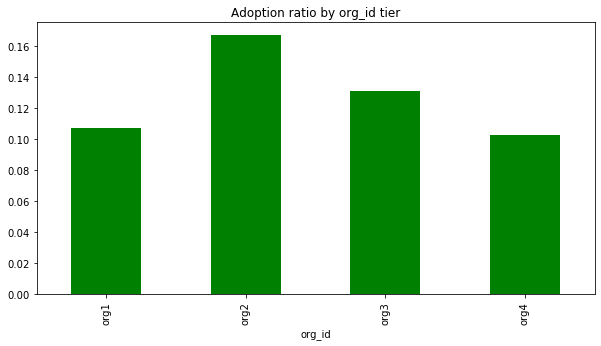

In [329]:
(users_df.groupby('org_id').is_adopted.sum()/
 users_df.groupby('org_id').org_id.count()).plot.bar(color='green', figsize=(10,5))

plt.title("Adoption ratio by org_id tier");

<font size="3">
Similar story with 'invited_by_user_id'. Some users are more active in inviting others than their peers:
</font>

In [249]:
users_df.groupby('invited_by_user_id').is_adopted.sum().unique()

array([0., 1., 2., 3., 4.])

In [251]:
inviting_group = users_df.groupby('invited_by_user_id').is_adopted.sum()
users_df['invited_by_user_id'] = users_df.invited_by_user_id.apply(
    lambda x: inviting_group[x] if not np.isnan(x) else -1) # add category level -1 for NaN values.

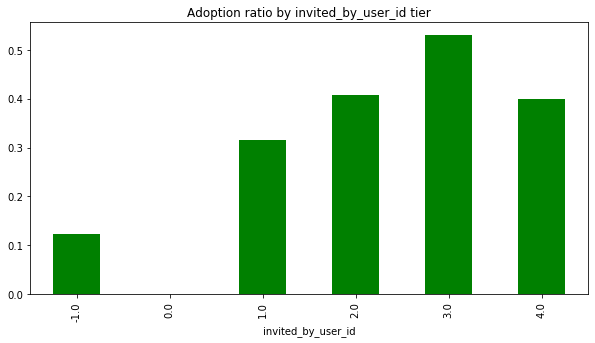

In [323]:
(users_df.groupby('invited_by_user_id').is_adopted.sum()/
 users_df.groupby('invited_by_user_id').invited_by_user_id.count()).plot.bar(color='green', figsize=(10,5))

plt.title("Adoption ratio by invited_by_user_id tier");

<font size="3">
Let's also check the adoption rate for different types of creation source:
</font>

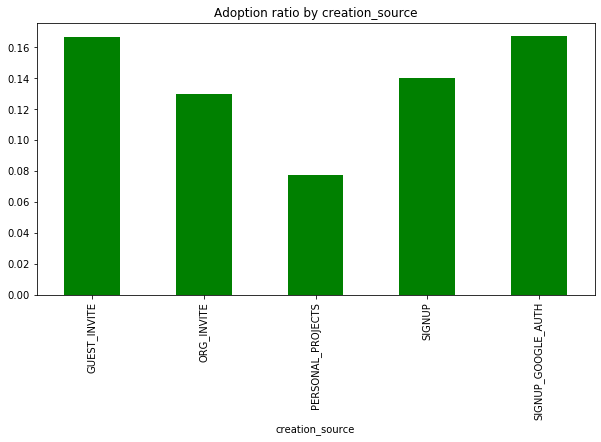

In [328]:
(users_df.groupby('creation_source').is_adopted.sum()/
 users_df.groupby('creation_source').creation_source.count()).plot.bar(color='green', figsize=(10,5))

plt.title("Adoption ratio by creation_source");

<font size="3">

**New features**:
While 'creation_time' and 'last_session_creation_time' seem not useful for any machine learning pipeline processing, we can derive two new featues out of them:
    
- 'last-first_login': The number of hours between the last sign-in and the account creation.
- 'recency': an index (in number of hours) of how recent was the last sign-in. We could subtract 'last_session_creation_time' from any reference time. In this case, we chose the last sign-in in the dataset as the reference. The choice of reference should not change the analysis much.
</font>

In [252]:
users_df['last-first_login'] = (users_df['last_session_creation_time'] - 
                                users_df['creation_time']).astype('timedelta64[h]')

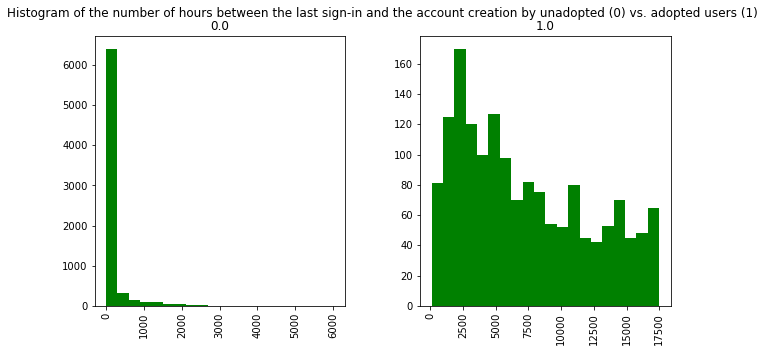

In [327]:
users_df['last-first_login'].hist(by=users_df['is_adopted'], 
                                      bins=20, density=False, 
                                      figsize=(10,5), color='green');
plt.suptitle("Histogram of the number of hours between the last sign-in and the account creation " \
             "by unadopted (0) vs. adopted users (1)");


In [298]:
users_df['recency'] = (max(users_df['last_session_creation_time']) - 
                                users_df['last_session_creation_time']).astype('timedelta64[h]')

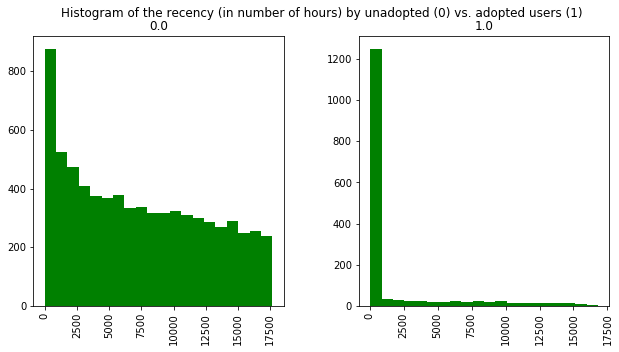

In [325]:
users_df['recency'].hist(by=users_df['is_adopted'], 
                                      bins=20, density=False, 
                                      figsize=(10,5), color='green');
plt.suptitle("Histogram of the recency (in number of hours) by unadopted (0) vs. adopted users (1)");

<font size="3">
    
<i> **Important Note: From the exploratory data analysis above, we expect the newly derived features exhibit high predictive power.** </i>
</font>

<font size="3">

**Dataframe for the predictive modelling: model_df**
    
Next we drop  the features we won't use and convert the categorical features to one-hot encoding format.
</font>

In [299]:
columns_to_drop = ['creation_time', 'name', 'email', 'last_session_creation_time']
model_df = users_df.drop(columns=columns_to_drop)

In [300]:
categorical_columns = ['creation_source', 'org_id', 'invited_by_user_id']
model_df = pd.get_dummies(data=model_df, columns=categorical_columns)

<font size="3">
Drop user IDs with no is_adopted labels:
</font>

In [301]:
model_df.dropna(inplace=True)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 20 columns):
opted_in_to_mailing_list              8823 non-null int64
enabled_for_marketing_drip            8823 non-null int64
is_adopted                            8823 non-null float64
last-first_login                      8823 non-null float64
recency                               8823 non-null float64
creation_source_GUEST_INVITE          8823 non-null uint8
creation_source_ORG_INVITE            8823 non-null uint8
creation_source_PERSONAL_PROJECTS     8823 non-null uint8
creation_source_SIGNUP                8823 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    8823 non-null uint8
org_id_org1                           8823 non-null uint8
org_id_org2                           8823 non-null uint8
org_id_org3                           8823 non-null uint8
org_id_org4                           8823 non-null uint8
invited_by_user_id_-1.0               8823 non-null uint8
invited_by_user_

## Predictive Modelling: Gradient Boosting Classifier

<font size="3">
<br>
Given the proven performance of Gradient Boosting classifiers for probelms with imbalanced datasets in particular, we will use this model. Also, we choose $F_{1}$ score as the metric for choosing the best hyper-parameters when cross-validating. The reason for this choise is that it is a function of recall and precision for postive lablels (=1) as opposed to accuracy that shows an artificially a high number by classifying all users' adoptions as zeros.
    
We also use startified tarin-test split of 75%:25% ratio.


</font>

In [302]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

y = model_df.pop('is_adopted')
X = model_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=50, stratify=y)

In [303]:
gb = GradientBoostingClassifier(max_features='sqrt')
grid = {'n_estimators':[40,45,50,55,60,65,70],'learning_rate':[.01,0.02,0.03,0.04,0.05,0.06,0.07],
              'max_depth':[1,2,3,4,5,6,7]}

cv_gb = GridSearchCV(estimator=gb, param_grid=parametergra, scoring='f1',cv=5)
cv_gb.fit(X_train,y_train)
best_para_gra = cv_gb.best_params_
best_acc_gra = cv_gb.best_score_

print('Tuned parameters :\n',cv_gb.best_params_,'\nAchieved score', cv_gb.best_score_)

Tuned parameters :
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 60} 
Achieved score 0.9285161020170692


In [304]:
from sklearn.metrics import f1_score, accuracy_score
print("Confusion matrix of the best estimator:")
y_pred = cv_gb.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("\nF_1 score (test dataset):",f1_score(y_test, y_pred))

Confusion matrix of the best estimator:
[[1788   17]
 [  40  361]]

F_1 score (test dataset): 0.926829268292683


## Model performance
<font size="3">
<br>
A very high $F_1$ score of 0.93 for both validation and test set and 97% accuracy for the test set. Also it correctly predicted 90% of adopted users. Therefore, we can rely on this model to get a sense of what features are importants.
</font>

In [308]:
print("\nAccuracy score (test dataset):",accuracy_score(y_test, y_pred))


Accuracy score (test dataset): 0.9741613780598368


## Importance of the features

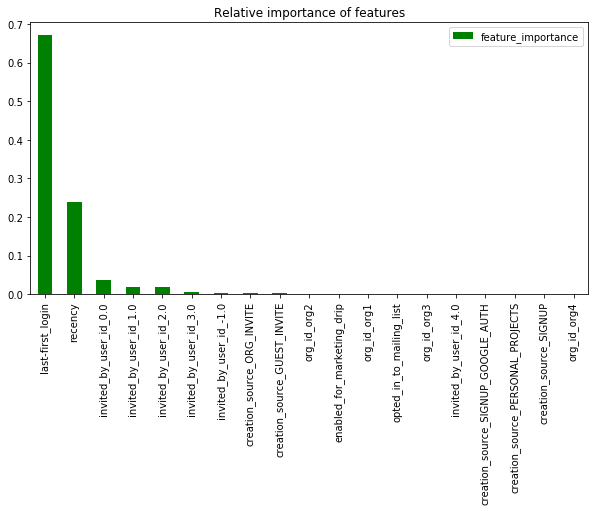

In [309]:
importance_df = pd.DataFrame(cv_gb.best_estimator_.feature_importances_, 
                 index=X.columns, columns=['feature_importance']).sort_values(by='feature_importance', 
                                                                              ascending=False)

importance_df.plot.bar(color='green', figsize=(10,5))
plt.title('Relative importance of features');

## Conclusion
<font size="3">
<br>

The duarion between the last sign-in and the account creation dates as well as recency of the logins are the most important actors predict future user adoption, followed by referrals by the different group of the current users. We found out the aforementioned conclusion by reading and cleaning the datasets, deriving new features, and building a reliable predictive model with 0.93 $F_1$ and 97% accuracy scores. 


</font>